In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 200
dim = 2
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, dim)
CFL = 0.3
goalRadius = 0.8

gamma = 5/3
nx = 100
rho0 = 1
E0 = 1

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.OwenScheme

domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [3]:
from sedov import buildSedov, radius, velocity, beta
import sphMath.reference.sedov as sedov
from scipy.optimize import minimize

particleSystem = buildSedov(nx, dim, domainExtent = 2, periodicDomain=True, rho0=rho0, E0 = E0, initialization = 'quadrant', gamma = gamma, kernel = kernel, targetNeighbors = targetNeighbors, dtype = dtype, device = device, shellSampling= False, SimulationSystem = SimulationSystem) 

dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)

answer = sedov.SedovSolution(
    nDim = dim,
    gamma = solverConfig['fluid']['gamma'],
    rho0 = rho0,
    E0 = E0,
    h0 = 2/nx
)
nu1 = 1.0/(answer.nu + 2.0)
nu2 = 2.0*nu1
goalTime = (goalRadius*(answer.alpha*rho0/E0)**nu1)**(1.0/nu2)
vs, r2, v2, rho2, P2 = answer.shockState(goalTime)
rad_t = lambda t: radius(beta(dim), E0, t, rho0, dim)
targetTime = minimize(lambda t: (rad_t(t) - goalRadius) ** 2, 0.2).x[0]

print(f'Target Time [paper]: {targetTime:8.4g}, {rad_t(targetTime):8.4g} / {answer.shockState(targetTime)[1]:8.4g}')
print(f'Target Time  [code]: {goalTime:8.4g}, {rad_t(goalTime):8.4g} / {answer.shockState(goalTime)[1]:8.4g}')


True: dxs: [tensor(0.0200, device='cuda:0'), tensor(0.0200, device='cuda:0')], ns: [tensor(100, device='cuda:0', dtype=torch.int32), tensor(100, device='cuda:0', dtype=torch.int32)], nx: 100
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001
Target Time [paper]:   0.5102,      0.8 /   0.8241
Target Time  [code]:   0.4808,   0.7766 /      0.8


In [4]:
from sedov import buildSedov


particleSystem = buildSedov(dim = 2,nx = nx, domainExtent = 2, periodicDomain = True, rho0 = rho0, E0 = E0, initialization = 'hat', gamma = gamma, kernel = kernel, targetNeighbors = targetNeighbors, dtype = dtype, device = device, shellSampling= False, SimulationSystem = SimulationSystem)
fluidParticles = particleSystem.systemState


simulationState = copy.deepcopy(particleSystem)
dtCFL = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
# dt = 1e-5

print(f'Initial dt: {dt}, CFL limit {dtCFL : .3e}, Courant Number: {1 / (dtCFL/dt / 0.3):.4g}')

kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy
    
print(f'Initial Kinetic Energy: {kineticEnergy:.4g}, Thermal Energy: {thermalEnergy:.4g}, Total Energy: {totalEnergy:.4g}')

print(f'Total Mass: {simulationState.systemState.masses.sum()}')

# filePrefix = './simulations/sedov_2d'
# os.makedirs(filePrefix, exist_ok = True)
# writeState(simulationState, f'{filePrefix}/initial_state.pt')

imagePrefix = './images/sedov_2d'
os.makedirs(imagePrefix, exist_ok = True)

# simulationState, currentState, updates = integrator(simulationState, dt, scheme, solverConfig, verbose = True)

True: dxs: [tensor(0.0200, device='cuda:0'), tensor(0.0200, device='cuda:0')], ns: [tensor(100, device='cuda:0', dtype=torch.int32), tensor(100, device='cuda:0', dtype=torch.int32)], nx: 100
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001
Initial dt: 0.00011578883277252316, CFL limit  2.860e-04, Courant Number: 0.1215
Initial Kinetic Energy: 0, Thermal Energy: 1, Total Energy: 1
Total Mass: 4.0


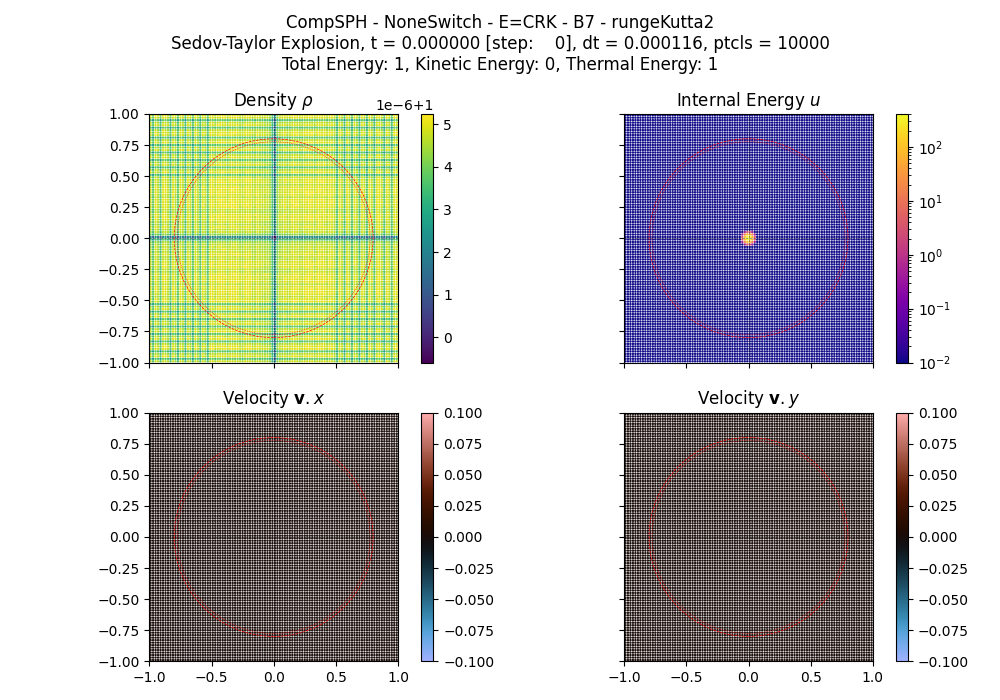

In [7]:
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH, evaluateOptimalSupportOwen

fluidParticles = simulationState.systemState

fig, axis = plt.subplots(2, 2, figsize=(10, 7), squeeze=False, sharex=True, sharey=True)


densityPlotState = visualizeParticles(fig, axis[0,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.densities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'viridis',
                     title='Density $\\rho$',
                     markerSize = 0.5)

internalEnergyPlotState = visualizeParticles(fig, axis[0,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.internalEnergies, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'plasma',
                     title='Internal Energy $u$',
                     scaling = 'log',
                     vmin = 1e-2,
                     markerSize = 0.5)

velocityXPlotState = visualizeParticles(fig, axis[1,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.velocities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'berlin',
                     midPoint=0,
                     title='Velocity $\mathbf{v}.x$',
                     mapping = '.x',
                     markerSize = 0.5,
                     gridVisualization=False)
velocityYPlotState = visualizeParticles(fig, axis[1,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.velocities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'berlin',
                     midPoint=0,
                     title='Velocity $\mathbf{v}.y$',
                     mapping = '.y',
                     markerSize = 0.5,
                     gridVisualization=False)

for ax in axis.flatten():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)
kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy
    
    
fig.suptitle(f'{solverConfig["schemeName"]}\nSedov-Taylor Explosion, t = {simulationState.t:2f} [step: {0:4d}], dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')

fig.tight_layout()
i = 0

r_t_code = answer.shockState(goalTime)[1]
r_t_paper = rad_t(goalTime)

for ax in axis.flatten():
    ax.axvline(0, color = 'black', linestyle = '--', lw = 0.5, alpha = 0.5)
    ax.axhline(0, color = 'black', linestyle = '--', lw = 0.5, alpha = 0.5)

    ax.add_artist(plt.Circle((0, 0), r_t_code, color='red', fill=False, lw=0.5, ls = '--'))
    ax.add_artist(plt.Circle((0, 0), r_t_paper, color='red', fill=False, lw=0.5, ls = ':'))

# fig.savefig(f'{imagePrefix}/frame_{0:06d}.png')

In [8]:

import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

imagePrefix = './images/sedov_2D/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

Current dt: 0.00011578883277252316
Plot Interval: 40
export Steps: 173
New dt: 0.00011560693641618497


In [9]:
states = []
timesteps = int(goalTime / dt)
# plotInterval = 100

for i in (tq:=tqdm(range(timesteps))):
# while(True):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = simulationState.priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    if i%100 == 0:
        states.append(copy.deepcopy(simulationState).to(dtype = torch.float32, device = 'cpu'))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.cpu().item(),
        'Thermal Energy': thermalEnergy.cpu().item(),
        'Total Energy': totalEnergy.cpu().item(),
        'Time': simulationState.t.cpu().item() if isinstance(simulationState.t, torch.Tensor) else simulationState.t,
    })

    if (i % plotInterval == 0 and i > 0) or i == timesteps - 1:
        updatePlot(densityPlotState, simulationState.systemState, simulationState.systemState.densities)
        updatePlot(internalEnergyPlotState, simulationState.systemState, simulationState.systemState.internalEnergies)
        updatePlot(velocityXPlotState, simulationState.systemState, simulationState.systemState.velocities, mapping = '.x')
        updatePlot(velocityYPlotState, simulationState.systemState, simulationState.systemState.velocities, mapping = '.y')
        
        for ax in axis.flatten():
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1,1)
        
        fig.suptitle(f'{solverConfig["schemeName"]}\nSedov-Taylor Explosion, t = {simulationState.t:2f} [step: {i:4d}], dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')


        t_ = simulationState.t.cpu().item() if isinstance(simulationState.t, torch.Tensor) else simulationState.t
        r_t_code = answer.shockState(t_)[1]
        r_t_paper = rad_t(t_)
        for ax in axis.flatten():
            for a in ax.patches:
                a.remove()
                

        for ax in axis.flatten():
            # ax.axvline(0, color = 'black', linestyle = '--', lw = 0.5, alpha = 0.5)
            # ax.axhline(0, color = 'black', linestyle = '--', lw = 0.5, alpha = 0.5)

            ax.add_artist(plt.Circle((0, 0), r_t_code, color='red', fill=False, lw=0.5, ls = '--', alpha = 0.5))
            ax.add_artist(plt.Circle((0, 0), r_t_paper, color='red', fill=False, lw=0.5, ls = ':', alpha = 0.5))

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)

  0%|          | 0/4152 [00:00<?, ?it/s]

In [10]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'sedov_2D',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!
